# Dermatology Analysis

#### Tariq Hassan, Jan. 2018.

---

## Introduction


In this report I will be exploring the *Dermatology Data Set* from the UCI Machine Learning Repository (available [here](http://archive.ics.uci.edu/ml/datasets/Dermatology)). This dataset contain 34 predictors for six kinds of erythemato-squamous diseases (ESD). These features are divided into two classes: 'clinical' and 'histopathological' features. The former can be obtained simply by inspecting the skin or asking the patient a simple question (e.g., "do you have a history of this disease in your family, yes or no?"). The latter requires analysis in a medical laboratory.


This project aims to find the most predictive of the *clinical* features for predicting the presence of ESDs. Specifically, I am to find the five most predictive clinical features, out of the twelve provided in the dataset. There is nothing especially magical about the number five here, but by keeping the number of features low there is reduced difficulty in a human remembering all of the important predictors. In short, I would like, by the end of these document, to finish this sentence: "The top five clinical predictors of ESDs are: ...". Moreover, I'd like to be able to tell readers just how powerful these features are in predicting these diseases.

In this project, not only would I like to have an output that is easy to understand, but obtain this result using a model that is also easy to grasp. So, I've opted to use random forests, as they can easily be converted into rules for a human to follow. 

---

## Dependencies

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from pprint import pprint
import matplotlib as matplt
import matplotlib.pyplot as plt
from pandas_ml import ConfusionMatrix

from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.neighbors import NearestNeighbors as KNN
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# dermatology_analysis
from dermatology_analysis.support_tools import dist, list_to_df

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(style="ticks", color_codes=True)

# Increae the default figure size for matplotlib:
# See: https://stackoverflow.com/a/36368418/4898004.
plt_size = np.array(matplt.rcParams['figure.figsize']) * 1.25
matplt.rcParams['figure.figsize'] = plt_size

In [2]:
# Suppres warnings from sklearn.
# See: https://stackoverflow.com/a/33616192/4898004
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
%%javascript
var rate = 0;
// apply setting to  all current CodeMirror instances
IPython.notebook.get_cells().map(
    function(c) {return c.code_mirror.options.cursorBlinkRate=rate;}
);

// make sure new CodeMirror instance also use this setting
CodeMirror.defaults.cursorBlinkRate=rate;

<IPython.core.display.Javascript object>

---

## Load the Data

In [4]:
from dermatology_analysis.clean import df  # load clean data
from data.descriptions import clinical, class_labels

In [5]:
# Clinical Features
clinical_cols = sorted(clinical.values())

In [6]:
df.head()

,disease,erythema,scaling,definite_borders,itching,koebner_phenomenon,polygonal_papules,follicular_papules,oral_mucosal_involvement,knee_and_elbow_involvement,scalp_involvement,family_history,age
0,Seboreic Dermatitis,2,2,0,3,0,0,0,0,1,0,0,55.0
1,Psoriasis,3,3,3,2,1,0,0,0,1,1,1,8.0
2,Lichen Planus,2,1,2,3,1,3,0,3,0,0,0,26.0
3,Psoriasis,2,2,2,0,0,0,0,0,3,2,0,40.0
4,Lichen Planus,2,3,2,2,2,2,0,2,0,0,0,45.0


## Data Overview

**Clinical Features:**

In [7]:
list_to_df(clinical_cols)

,,,,
,age,definite_borders,erythema,family_history
,follicular_papules,itching,knee_and_elbow_involvement,koebner_phenomenon
,oral_mucosal_involvement,polygonal_papules,scaling,scalp_involvement


As noted in the data's description:

* age is a real-valued scalar
* family history is 1 if the disease is present in the family, zero otherwise.

All other features are in $\{0, 1, 2, 3\}$, where $0$ represents the lack of the feature, $3$ its presence in the most sever state and $1$, $2$ denoting relative intermediate values.

---

Lastly, the `disease` column represents the labels, which can be one of the following diseases:  

In [8]:
list_to_df(class_labels.values(), n=len(class_labels)).T

,
,Psoriasis
,Seboreic Dermatitis
,Lichen Planus
,Pityriasis Rosea
,Cronic Dermatitis
,Pityriasis Rubra Pilaris


---

## Exploratory Data Analysis

### Count the number of each label:

In [9]:
df.groupby('disease')['disease'].count().sort_values()

disease
Pityriasis Rubra Pilaris     20
Pityriasis Rosea             49
Cronic Dermatitis            52
Seboreic Dermatitis          61
Lichen Planus                72
Psoriasis                   112
Name: disease, dtype: int64

Note: classes are not balanced. This could be a big problem, especially with something like Random forrests (my starting point), as the number of observations in each bag may not be balanced. Thankfully, sklearn's `RandomForestClassifer()` class has a `class_weight` param where, if left to it's default of `'balanced'`, weights using `n_samples / (n_classes * np.bincount(y))`. I'll cautiously accept this as a solution.

### Missing Values

We know that there are eight ages missing from the data's description. These rows are shown below.

In [10]:
df[pd.isna(df['age'])]

,disease,erythema,scaling,definite_borders,itching,koebner_phenomenon,polygonal_papules,follicular_papules,oral_mucosal_involvement,knee_and_elbow_involvement,scalp_involvement,family_history,age
33,Psoriasis,2,2,1,0,0,0,0,0,1,0,1,NaN
34,Pityriasis Rosea,2,1,0,0,2,0,0,0,0,0,0,NaN
35,Seboreic Dermatitis,2,2,1,2,0,0,0,0,0,0,0,NaN
36,Lichen Planus,2,1,2,3,2,3,0,2,0,0,1,NaN
262,Cronic Dermatitis,2,1,0,2,0,0,0,0,0,0,0,NaN
263,Cronic Dermatitis,1,1,1,3,0,0,0,0,0,0,0,NaN
264,Cronic Dermatitis,1,1,0,2,0,0,0,0,1,0,0,NaN
265,Cronic Dermatitis,1,1,0,3,0,0,0,0,0,0,0,NaN


For the purpose of this report, I will simply be dropping these rows (complete-case). It should be noted that this may not be without issue. Namely, it is not clear if these missing data are so-called missing completely at random (MCAR). If they're not, and the reason for the absence of this data isn't *completely* random, then this action is liable to introduce bias into the results.

In [11]:
df = df[~pd.isna(df['age'])].reset_index(drop=True)

---

*Compute averages for clinical features:*

In [12]:
disease_avgs = df.groupby('disease')[clinical_cols].mean().sort_values('age').T.reset_index()
disease_avgs = disease_avgs.rename(columns={'index': 'feature'}).reset_index(drop=True)
disease_avgs.columns.name = None

For now, let's just look at age and family hitory:

In [13]:
disease_avgs[disease_avgs['feature'].map(
    lambda x: x in ('age', 'family_history'))].reset_index(drop=True)

,feature,Pityriasis Rubra Pilaris,Pityriasis Rosea,Seboreic Dermatitis,Cronic Dermatitis,Psoriasis,Lichen Planus
0,age,10.25,35.270833,35.466667,36.666667,39.378378,39.957746
1,family_history,0.50,0.000000,0.050000,0.000000,0.279279,0.000000


> It appears that the average age for most of these illness is the smale (mid to late thirties), with the notable exception of pityriasis rubra pilaris. It also has the strongest family history, as 50% of these patients had family members with the illness. Psoriasis also appears to have a heritible component.


We can now look at the whole table:

In [14]:
disease_avgs

,feature,Pityriasis Rubra Pilaris,Pityriasis Rosea,Seboreic Dermatitis,Cronic Dermatitis,Psoriasis,Lichen Planus
0,age,10.25,35.270833,35.466667,36.666667,39.378378,39.957746
1,definite_borders,1.05,1.208333,0.950000,0.895833,2.108108,2.098592
2,erythema,2.05,1.895833,2.283333,1.520833,2.288288,2.084507
3,family_history,0.50,0.000000,0.050000,0.000000,0.279279,0.000000
4,follicular_papules,2.20,0.000000,0.016667,0.250000,0.036036,0.000000
5,itching,0.50,0.479167,1.616667,1.833333,0.954955,2.267606
6,knee_and_elbow_involvement,1.70,0.000000,0.066667,0.020833,1.639640,0.028169
7,koebner_phenomenon,0.00,1.166667,0.033333,0.000000,0.675676,1.338028
8,oral_mucosal_involvement,0.00,0.000000,0.000000,0.000000,0.000000,1.915493
9,polygonal_papules,0.00,0.000000,0.000000,0.000000,0.000000,2.267606


> Sadly, the whole table is a little dense to read, so let's plot it instead.

In [15]:
# Save data as .feather and plot in R:
pd.melt(disease_avgs, id_vars=['feature'], value_vars=None).rename(
    columns={'variable': 'disease'}).to_feather('data/intermediate/disease_avgs_melt.feather')

Plot Generated by `ggplot2`:

![](figures/plot1.png)

Note: I have excluded `Family History` and `Age` as these are not on a 0 - 3 scale.

This gives us an idea of the . Namely, while these are different features, they share severity accross many different clinical features. For instance, erythema, or redness of the skin, tends to be moderatley to quite sever in almost all of these illness. 

Another way to invetigate this visually is to create a heatmap (using *all* of the clinical features).

In [16]:
def distance_heatmap(avg_data_frame):
    # Compute distance matrix (normalize rows vectors to have mean zero, unit variance) ---
    disease_avgs_sans_features = avg_data_frame.drop("feature", axis=1)
    disease_avgs_sans_features_scaled = scale(disease_avgs_sans_features, axis=1)
    distance_mat = dist(disease_avgs_sans_features_scaled.T)

    # Convert to a DataFrame ---
    distance_df = pd.DataFrame(distance_mat)
    distance_df.columns = disease_avgs_sans_features.columns
    distance_df.index = disease_avgs_sans_features.columns

    # Plot ---
    return sns.heatmap(distance_df)

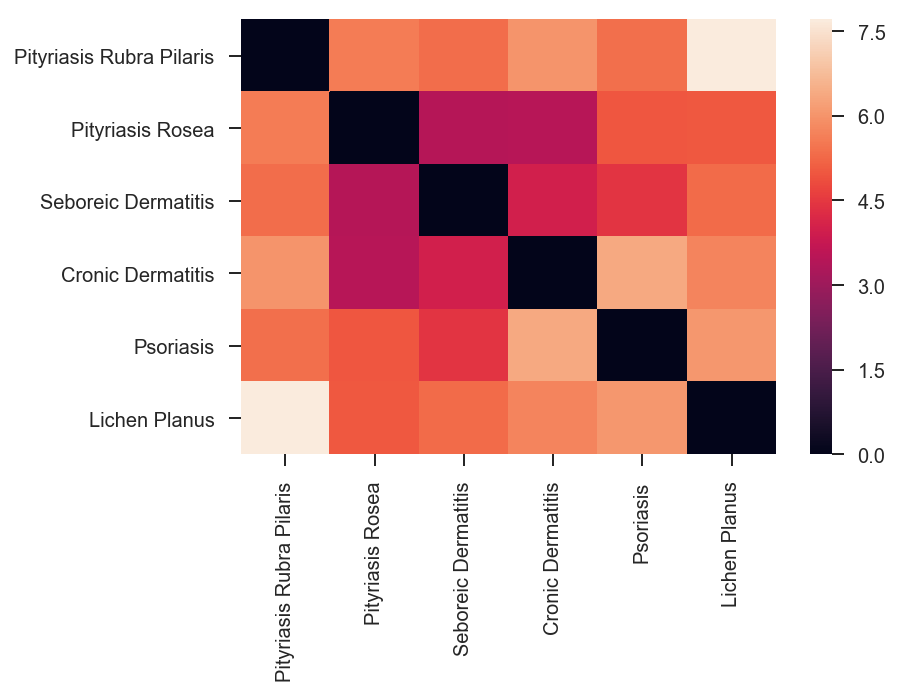

In [17]:
_ = distance_heatmap(disease_avgs)

*Lighter colors denote greater distance appart (i.e., greater dissimilarity).*

The plot has been generated by:

* Representing each disease by as a column vector of the the 12 features in table of averages above.
* Normalizing each feature accross all diseases (i.e., each row in the full table was made to have mean zero and unit variance).
* Computing the euclidean distance between each of the column vectors, generating an nxn distance matrix, where n is the number of diseases.
* Plotting this distance matrix.

To take some examples, this allows us to see that Seboreic Dermatitis and Pityriasis Rosea are similar, as are Cronic Dermatitis and Pityriasis Rosea. The model may struggle to tell these diseases appart. Conversely, Lichen Planus and Pityriasis Rubra Pilaris are appear to be quite distinct. It may find it easier to tell these illnesses appart.

Of course, we should be cautious reading too much into this plot because it is built ontop of a *summary statistic*: the *mean*. So, let's actually move on to modeling itself.

---

## Feature and Model Selection

### Data:

In [18]:
features_df = df.drop('disease', axis=1)
feature_names = features_df.columns.tolist()

X = features_df.values  # Features
y = df['disease'].values  # targets

In [19]:
# Hold out 10% for testing at the end
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=1)

---

### Feature Selection

I will chose the best $5$ features, using the default hyperparemeter settings for `RandomForrests()`.

To do this feature selection I will be using Recursive Feature Elimination (RFE, see [here](http://scikit-learn.org/stable/modules/feature_selection.html#rfe)):

In [20]:
n_features_to_select = 5
rf_rfe = RFE(RandomForest(random_state=7), n_features_to_select).fit(X_train, y_train)

In [21]:
# Convert the selected column indicies back into column names:

rankings_dict = {feature_names[e]: ranking for e, ranking in enumerate(rf_rfe.ranking_)}

rankings_df = pd.DataFrame([rankings_dict])
rankings_df = (rankings_df.T
               .rename(columns={0: 'ranking'})
               .sort_values('ranking')
               .reset_index().rename(columns={'index': 'feature'}))

rankings_df['included'] = rankings_df.index < n_features_to_select
rankings_df

,feature,ranking,included
0,age,1,True
1,knee_and_elbow_involvement,1,True
2,koebner_phenomenon,1,True
3,polygonal_papules,1,True
4,scalp_involvement,1,True
5,scaling,2,False
6,itching,3,False
7,definite_borders,4,False
8,oral_mucosal_involvement,5,False
9,erythema,6,False


Above we can see the top five features that we found to be most helpful in predicting `y`. 

Interestingly, some of the well-known markers to watch for, such as definite borders, did not make it into the top 5 most predictive features. 

#### Filter the `X_train` and `X_test` matrices accordingly:

In [22]:
X_train = X_train[:, rf_rfe.support_]
X_test = X_test[:, rf_rfe.support_]

In [23]:
support_col = features_df.columns[rf_rfe.support_]

---

### Model Selection

Next, I'll use cross-validated grid search to find the 'best' value for hyperparameters, given the features that have been selected using the default hyperparameters.

Specifically, I will be searching over `n_estimators` and `max_depth`, trying to balance the fundemental trade off of machine learning.

In [24]:
params = {'n_estimators': list(range(1, 30, 4)), 
          'max_depth': list((range(1, 20, 4)))}
                                                                
rf = RandomForest(random_state=7)                                                                
rf_gcv = GridSearchCV(rf, params, n_jobs=-1)
_ = rf_gcv.fit(X_train, y_train)

This yeilds the following selection of hyperparameter values:

In [25]:
rf_gcv.best_params_

{'max_depth': 5, 'n_estimators': 9}

Which achieved the following error rate:

In [26]:
1 - rf_gcv.best_score_

0.24223602484472051

Next, we can plot all of the results to get a better idea of what `max_depth` of 5, and `n_estimators` of 17 'beat out' to be the best hyperprameters (of those searched over):

In [27]:
# Extract Relevant Results
results = pd.DataFrame(rf_gcv.cv_results_)[['param_n_estimators', 'param_max_depth', 'mean_test_score']]
results['mean_test_error'] = 1 - results['mean_test_score']

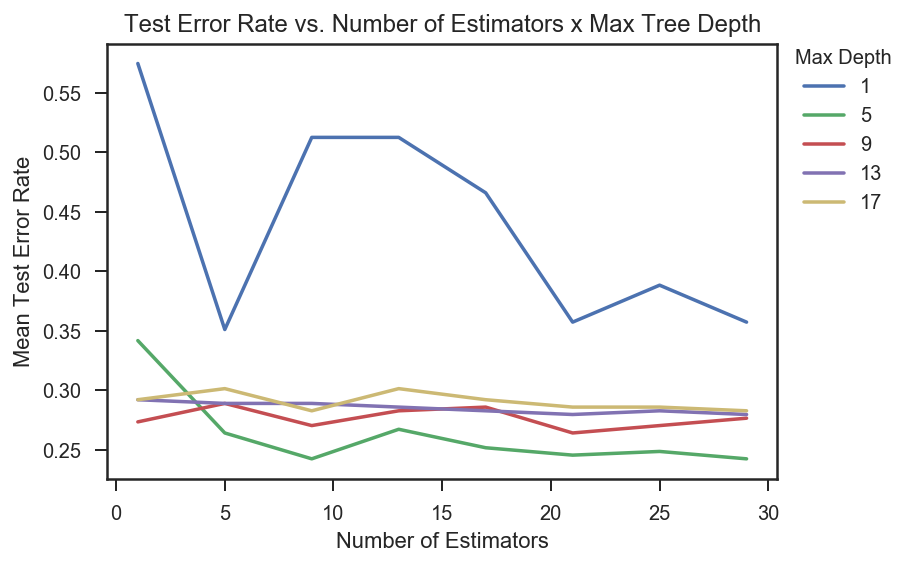

In [28]:
# Convert `results` to a dictionary
to_plot_dict = results.groupby('param_max_depth').apply(
    lambda x: dict(zip(x['param_n_estimators'], x['mean_test_error']))).to_dict()

# Draw lines
for max_depth, v in to_plot_dict.items():
    plt.plot(*zip(*v.items()), label=max_depth)
    
plt.ylabel("Mean Test Error Rate")
plt.xlabel("Number of Estimators")
plt.title("Test Error Rate vs. Number of Estimators x Max Tree Depth")
_ = plt.legend(title="Max Depth", loc='center left', bbox_to_anchor=(1, 0.8))

As can be seen above, progress large plateaus w.r.t. Number of Estimators after it hits five (no real additional benifit from the added complexity). More noticeably, `max_depth` initially makes a large difference (1 vs 5), but actually starts to hurt performance when allowed to increase beyond five (overfitting). 

---

## Testing

---

### Test Performance

In [29]:
"Error Rate on Test Data: {}.".format(round(1 - rf_gcv.score(X_test, y_test), 3))

'Error Rate on Test Data: 0.194.'

As can be seen above, the model has a ~19% error rate (on six classes), using just five features.

### Confusion Matrix

The next thing we can do is see where the model is making mistakes.

In [30]:
y_pred = rf_gcv.predict(X_test)
y_true = y_test

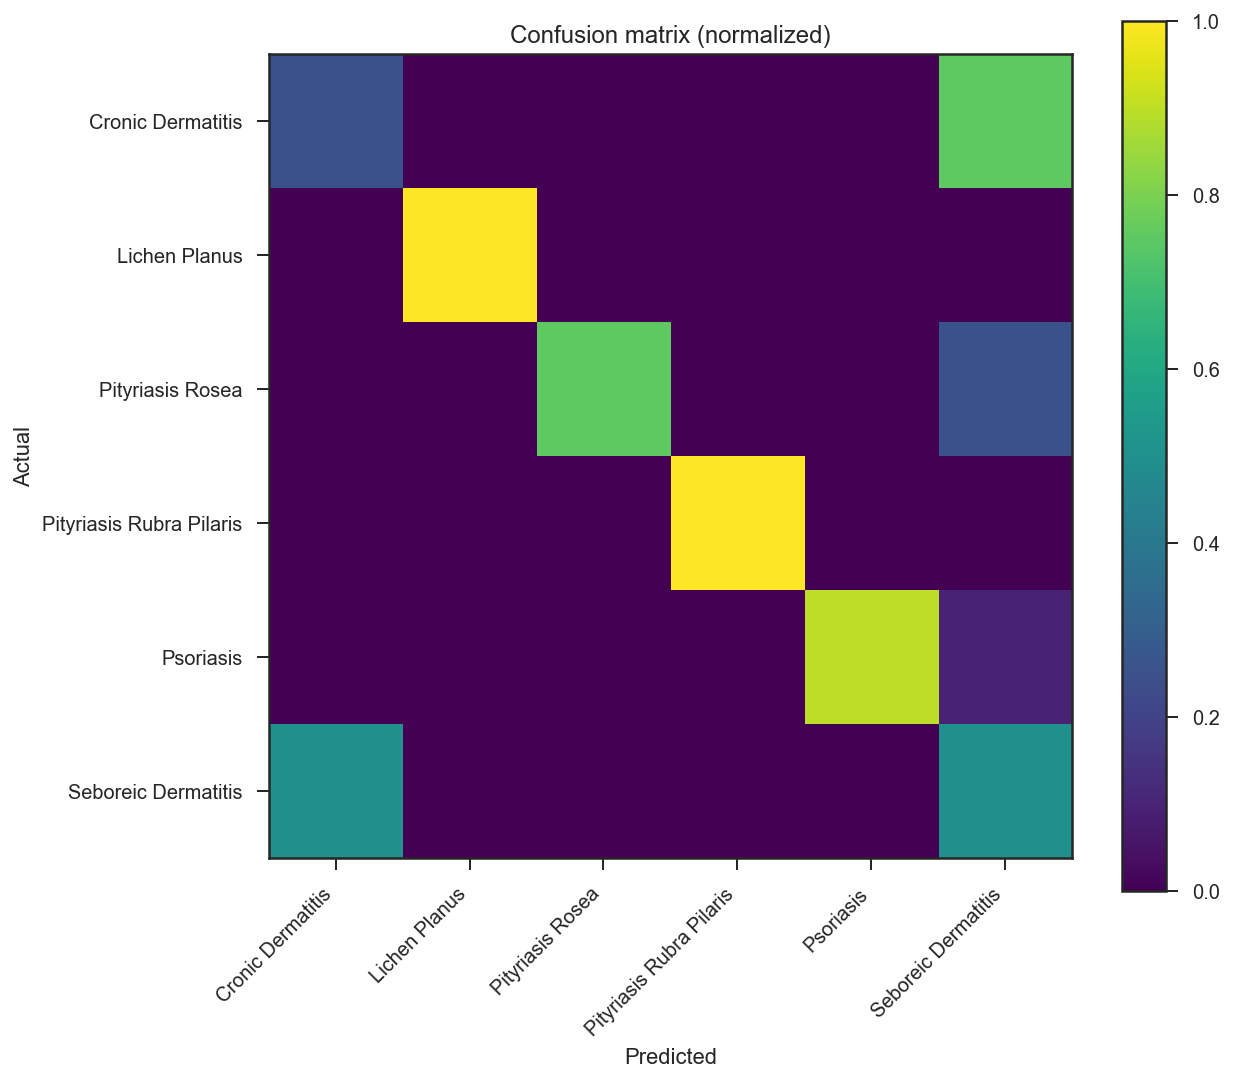

In [31]:
conf_mat = ConfusionMatrix(y_true, y_pred)
_ = conf_mat.plot(normalized=True, cmap='viridis')

Colors close to yellow indicate a higher proportion of predictions; colors close to blue indicate few predictions.

The idea plot would have a yellow diagonal (correct predictions) and blue elsewhere. Yet, we can observe some dark squares on the main diagonal, and some greenish/yellow plots off the main diagonal. In a word: confusion. To take a few examples, the model (a) seems to find to challenging to understand Cronic Dermatitis itself and (b) liable to confuse Cronic Dermatitis and Seboreic Dermatitis.

If we recall the distance heatmap from above (refined here to only include the selected features) we can see that the distance between Cronic Dermatitis and Seboreic Dermatitis is quite low on average:

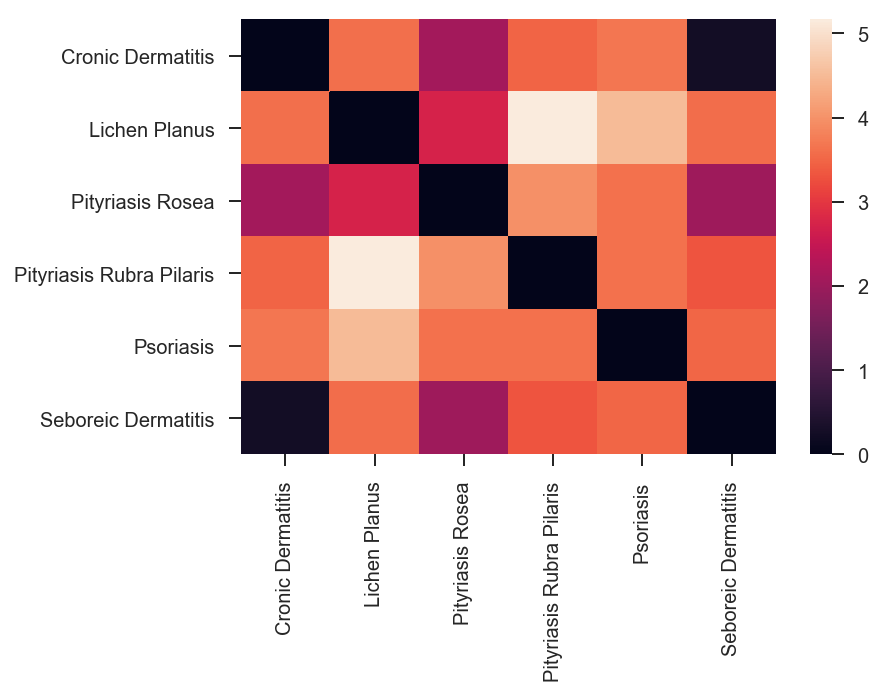

In [32]:
disease_avgs_conf = disease_avgs[disease_avgs['feature'].isin(support_col)]
order = ['feature', 'Cronic Dermatitis', 'Lichen Planus', 'Pityriasis Rosea',
         'Pityriasis Rubra Pilaris', 'Psoriasis', 'Seboreic Dermatitis']
_ = distance_heatmap(disease_avgs_conf[order])

---

## Conclusions

In this project I set out to find the top five most predictive clinical features of ESDs using Random Forests as my machine learning model of choice. With feature selection, I found the top five most predictive clinical features for ESDs were:

* Koebner Phenomenon
* Polygonal Papules
* Scalp Involvement
* Age
* Knee and Elbow Involvement

I then used performed model selection by performing hyperparameter optimization. This allowed me to build a model that achieved 19% error on the test data. So, complete the goal presented in my introduction: 

> The top five clinical predictors of ESDs are koebner phenomenon, polygonal papules, age, scalp involvement, as well as knee and elbow involvement. Using a random forests model these have allowed for 81% test accuracy".